# Projections of Probability Distributions, and the Reparameterization Trick

For approximate inference and learning, it's often necessary to approximate a target distribution $p$ with another distribution $q$ from a (restricted) set $Q$ of distributions. Here I demonstrate the two types of projections based on KL divergence, detailed in section 8.5 Daphne Koller's PGM textbook. I also demonstrate the score function trick (REINFORCE) and parameterization trick for variational inference in finding I-projections.

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from scipy.stats import norm

Let $p(x)$ be our target distribution, in this case a mixture of two scalar Gaussians, 
$$ p(x) = \pi_1 \mathcal{N}(x; \mu_1, \sigma^2_1) + \pi_2 \mathcal{N}(x; \mu_2, \sigma^2_2) $$

Let's plot its pdf:

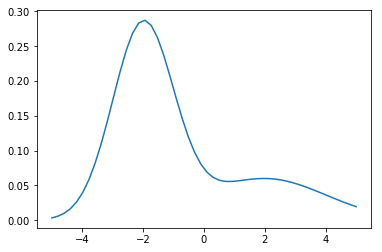

In [2]:
# let p(x) be the target distribution; example from Koller PGM text ex. 8.13, section 8.5.1, p. 275
pi1, mu1, sig1 = .7, -2, 1
pi2, mu2, sig2 = .3, 2, 2
def p_x(x):
    c1 = norm(mu1, sig1)
    c2 = norm(mu2, sig2)
    return pi1 * c1.pdf(x) + pi2 * c2.pdf(x)

# plot p(x)
xs = np.linspace(-5, 5)
plt.figure()
plt.plot(xs, p_x(xs))
plt.show()

We want to project $p$ onto the set of univariate normal distributions, $Q = \{\mathcal{N(\mu, \sigma^2)} \}$. Recall the commonly used distance measure, KL divergence (i.e., relative entropy) is not symmetric in its two arguments. Therefore we have two types of projections.

The **M-projection** is defined as 
$$ q^M = \arg \min_{q \in Q} D(p \| q), D(p \| q) = E_p[ \log p(X) - \log q(X)] = -H[p] - E_p[\log q(X)] $$

If $q(x)$ has some nice structure, then this optimization problem can be made easier. Indeed this is the case for exponential family distributions (so that $\log q(x)$ is a linear function of parameters). 
Theorem 8.6 says that if $Q$ is an exponential family with sufficient statistics $\psi(x)$ and parameterized by $\phi$, then the M-projection $q^M$, is equal to $q_\phi$ if $\mathbb{E}_{q_\phi}[\psi(X)] = \mathbb{E}_{p}[\psi(X)]$. In words, $q_\phi \in Q$ is the M-projection if it matches the expected sufficient statistics induced by $p$.

In our case, the univeriate Gaussian exponential family is defined by the vector of sufficient statisitics $[x, x^2]$, and for convenience let's parameterize $Q$ in mean parameters $\mathbb{E}[X] = \mu, \mathbb{E}[X^2] = \sigma^2 + \mu^2 $ (instead of natural parameters); it's easy to show that $q^M$ must have $[\hat \mu, \hat \sigma^2]$ as its mean parameters, where 
$$ \hat \mu = \mathbb{E}_p[X] $$
and
$$ \hat \sigma^2 = \mathbb{E}_p[X^2] - (\mathbb{E}_p[X])^2 = \mathbb{E}_p[X^2] - \hat \mu^2 $$
i.e., the mean and variance of the Gaussian M-projection must match those of the target distribution. 

In the example, we have direct access to $p$, so we could use numerical integration or sampling to find its first and second moments and thus $\hat \mu$ and $ \hat \sigma^2$. 
Note that in the general setting of learning a probabilistic model from data, we are often provided a set of samples $\mathcal{S}$ from the unknwon distribution $p$ and attempt to learn an approximation $q$ by maximum likelihood--and this corresponds precisely to finding the M-projection of the empirical distribution $\hat p$:  $$q^{MLE} = \arg \max_{q\in Q} \sum_{x \in \mathcal{S}} \log q(x) = \arg \min_{q\in Q} -\mathbb{E}_{\hat p} [\log q(X)] = \arg \min_{q\in Q} D(\hat p \| q)$$

D(p||q) = 0.161106854028


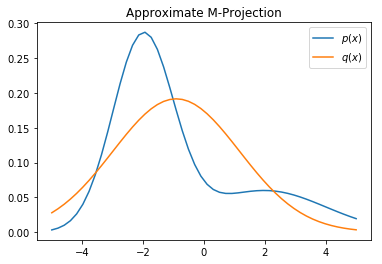

In [3]:
# find M-projection by numerical integration; may fail in high dimensions (use smart sampling methods instead)
xs = np.linspace(-5, 5, 50)
pxs = p_x(xs)
mu_hat = np.trapz(pxs * xs, xs)    # first moment
var_hat = np.trapz(pxs * xs**2, xs) - mu_hat**2    # second moment - (first moment)^2
sig_hat = var_hat ** 0.5
qxs = norm.pdf(xs, loc=mu_hat, scale=sig_hat)
obj = np.trapz(pxs * (np.log(pxs)-np.log(qxs)), xs)    # approximate D_KL(p||q)
print('D(p||q) =', obj)

# plot M-projection; by comparison I-projection avoids regions where p(x) is close to zero and appears "sharper"
plt.figure()
plt.plot(xs, pxs, label='$p(x)$')
plt.plot(xs, norm.pdf(xs, loc=mu_hat, scale=sig_hat), label='$q(x)$')
plt.legend(loc='best')
plt.title('Approximate M-Projection')
plt.show()

The **I-projection** is defined as 
$$ q^I = \arg \min_{q \in Q} D(q \| p), D(q \| p) = E_q[ \log q(X) - \log p(X)] = -H[q] - E_q[\log p(X)] $$

Unlike before, we no longer need to marginalize/integrate with respect to $p$, but we still need to deal with expectations (w.r.t. $q$). Generally, these expectations cannot be computed analytically, and some approximation is needed, even just to evaluate the objective.
Note that for a generic $p(x) = \tilde p(x) / Z$ where we don't necessarily know the partition function $Z$, e.g., in a Markov network, it's customary to maximize the evidence lower bound (ELBO): $ELBO = \log Z - D(q \| p) = \mathbb{E}_q[\log \tilde p(X)] + H[q]$, instead of minimizing $D(q\|p)$; these two approaches are equivalent. 

Here, ideas from general-purpose variational inference are often used for applying stochastic optimization to this problem, particularly "tricks" for computing derivatives of $E_q[ \log q(X) - \log p(X)]$ w.r.t. the parameters $\phi$ of $q$.

In our example, we know the entropy of Gaussian in closed form,
$$H[q] = \frac{1}{2} \log 2 \pi e \sigma^2 $$
so we only need to worry about finding the gradient $ \nabla_\phi \mathbb{E}_{q_\phi} [\log p(X)]$ w.r.t. parameters $\phi = (\mu, \sigma^2)$. Under most circumstances in practice we can exchange integration and differentiation:

$$ \nabla_\phi \mathbb{E}_{q_\phi} [ f(X) ] = \int_x f(x) \nabla_\phi q_\phi(x) dx $$

Often this integral is intractable; one idea for approximating it is to turn it into an expectation and use sampling.

Perhaps the first thing to try is multiplying and dividing the integrand by $q_\phi(x)$ (somewhat reminiscent of importance sampling):
$$ \nabla_\phi \mathbb{E}_{q_\phi} [ f(X) ] = \int_x q_\phi(x) f(x) \frac{\nabla_\phi q_\phi(x)}{q_\phi(x)} dx = \int_x q_\phi(x) f(x) [\nabla_\phi \log q_\phi(x)] dx = \mathbb{E}_{q_\phi} [ f(X) \nabla_\phi \log q_\phi(X)] $$
where we used the simple identity $\frac{\nabla_\phi q_\phi(x)}{q_\phi(x)} = \nabla_\phi \log q_\phi(x)$.
Now this expression is an expectation w.r.t. $q_\phi(x)$, so we can draw samples from $q_\phi(x)$ and approximate it. This technique is known as the ``score function trick'' or REINFORCE.

In our example, $f(x) = \log p(x)$ is the log pdf of the Gaussian mixture, $\log q(x)$ is the log pdf of our approximating Gaussian, and by simple algebra we have $$\nabla_\phi \log q_\phi(x)= [\frac{\partial}{\partial\mu} \log q_\phi(x), \frac{\partial}{\partial\sigma} \log q_\phi(x) ] = [ \frac{x-\mu}{\sigma^2}, -\frac{1}{\sigma} + \frac{(x-\mu)^2}{\sigma^3} ] $$

In [4]:
# score function estimator: grad E_q[-log P(x)] = E_q[-log p(x) * grad log q(x)]
# we have \partial log q / \partial mu = (x-mu)/(sigma**2), 
# \partial log q / \partial sigma = - 1/sigma + (x-mu)**2 * sigma**(-3)

def grad_log_q(x, mu, sigma):
    # x may be a length N vector of data points
    partial_mu = (x-mu)/(sigma**2)
    partial_sigma = - 1/sigma + (x-mu)**2 * sigma**(-3)
    return np.vstack([partial_mu, partial_sigma]).T    # N x 2 array for convenience


def est_grad(mu, sigma, num=1000):
    xs = np.random.normal(mu, sigma, num)  # samples from q
    neg_log_p_x = -np.log(p_x(xs))
    grad_h_q = [0, 1 / sigma]  # grad H[q]; 0 wrt mu
    grad = np.mean(neg_log_p_x[:, np.newaxis] * grad_log_q(xs, mu, sigma), axis=0) - grad_h_q  # approx grad of obj

    # estimate the optimization objective (KL_q_p)
    h_q = 0.5 * np.log(2 * np.pi * sigma ** 2)
    obj = -h_q + np.mean(neg_log_p_x)
    return grad, obj

t = 0 D(q||p) = 1.78176312345
t = 20 D(q||p) = 0.944366751202
t = 40 D(q||p) = 0.730673826087
t = 60 D(q||p) = 0.720010453942
t = 80 D(q||p) = 0.735620602677
t = 100 D(q||p) = 0.681848886175
t = 120 D(q||p) = 0.763892916983
t = 140 D(q||p) = 0.703759502188
t = 160 D(q||p) = 0.719445890011
t = 180 D(q||p) = 0.691542639593


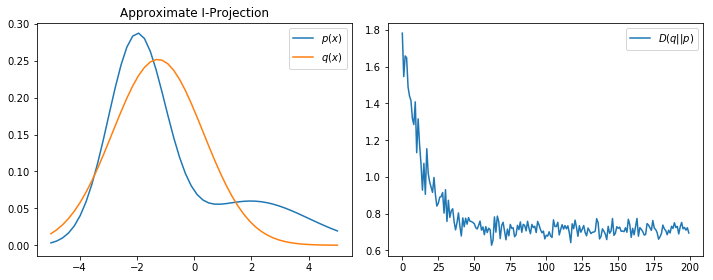

In [5]:
# let's do sgd
# intentionally bad initialization
mu = -2
sigma = 3
T = 200

eta = 0.05  # step size
objs = []  # keep a record
for t in range(T):
    grad, obj = est_grad(mu, sigma)
    if t % 20 == 0:
        print('t =', t, 'D(q||p) =', obj)
    objs.append(obj)
    mu, sigma = [mu, sigma] - eta * grad

# plot results
xs = np.linspace(-5, 5)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(xs, p_x(xs), label='$p(x)$')    # target p(x)
plt.plot(xs, norm.pdf(xs, mu, sigma), label='$q(x)$')    # I-projection q(x)
plt.legend(loc='best')
plt.title('Approximate I-Projection')

plt.subplot(1, 2, 2)
plt.plot(objs, label='$D(q||p)$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Another approach to finding $ \nabla_\phi \mathbb{E}_{q_\phi} [\log p(X)]$ is based on the observation that
$$X \sim q_\phi(X) = \mathcal{N}(\mu, \sigma^2)$$
is equivalent to
$$X = g_\phi(\epsilon) = \mu + \sigma \epsilon, \text{where } \epsilon \sim p(\epsilon) = \mathcal{N}(0, 1)$$
i.e., the process of generating $X$ from $q_\phi(X)$ is equivalent to first generating an underlying source of randomness $\epsilon \sim \mathcal{N}(0, 1)$, then transforming $\epsilon$ by a deterministic function $g$ governed by the parameters $\phi$. Now it makes sense to take derivative of the value of a random sample $x=g_\phi(\epsilon)$ w.r.t. parameters $\phi$: $\nabla_\phi x = \nabla_\phi g_\phi(\epsilon)$ measures the rate of change in $x$ from adjusting $\phi$, if we repeated the sampling process using the same noise source $\epsilon$.  We can make the following change of variable in the expectation $\mathbb{E}_{q_\phi} [\log p(X)]$:
$$ \int_x f(x) q_\phi(x) dx = \int_\epsilon f(x) p(\epsilon) d \epsilon = \int_\epsilon f(g_\phi(\epsilon)) p(\epsilon) d \epsilon $$
Note crucially that $\phi$ and $\epsilon$ have no functional dependence on each other. We can then differentiate w.r.t. $\phi$ as usual:
$$ \nabla_\phi \mathbb{E}_{q_\phi} [\log p(X)] =  \int_x f(x) \nabla_\phi q_\phi(x) dx = \int_\epsilon \nabla_\phi f(x) p(\epsilon) d \epsilon = \int_\epsilon \nabla_\phi f(g_\phi(\epsilon)) p(\epsilon) d \epsilon = \int_\epsilon f'(g_\phi(\epsilon)) [\nabla_\phi g_\phi(\epsilon)] p(\epsilon) d \epsilon $$

which now has the form of an expectation w.r.t. $p(\epsilon)$. This technique is called the Reparameterization Trick, popularized by the [Variational Autoencoder paper](https://arxiv.org/abs/1312.6114).

After some algebra, in our example we have
\begin{align}
f'(x) &= \frac{d}{d x} \log p(x) = -\frac{1}{p(x)} \{ \pi_1 \mathcal{N}(x; \mu_1, \sigma_1) \frac{x-\mu_1}{\sigma_1^2} + \pi_2 \mathcal{N}(x; \mu_2, \sigma_2) \frac{x-\mu_2}{\sigma_2^2} \} \\
\nabla_\phi g_\phi(\epsilon) &= [1, \epsilon]
\end{align}

t = 0 D(q||p) = 1.79964369771
t = 20 D(q||p) = 1.05578290301
t = 40 D(q||p) = 0.733509820609
t = 60 D(q||p) = 0.709207215267
t = 80 D(q||p) = 0.674809679004
t = 100 D(q||p) = 0.699469241391
t = 120 D(q||p) = 0.698766894145
t = 140 D(q||p) = 0.69433893559
t = 160 D(q||p) = 0.649860176551
t = 180 D(q||p) = 0.714982255485


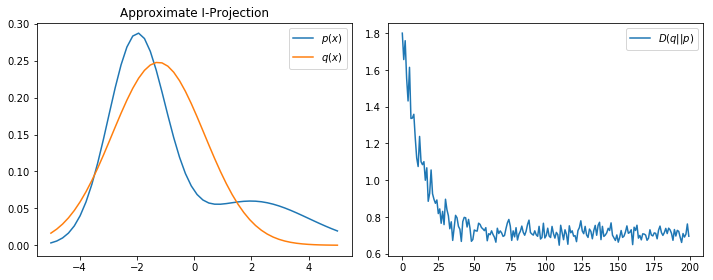

In [6]:
# SGD using the Reparameterization Trick for estimating cross entropy gradient
def dfdx(x):
    # x is allowed to be a length N vec of data points
    c1 = norm(mu1, sig1)
    c2 = norm(mu2, sig2)
    px = p_x(x)
    return -1/ px * (pi1 * c1.pdf(x) * (x-mu1) * sig1**(-2) + pi2 * c2.pdf(x) * (x-mu2) * sig2**(-2))

def g(eps, mu, sigma):
    return mu + sigma * eps

def est_grad_reparam(mu, sigma, num=1000):
    es = np.random.normal(0, 1, num)   # sample "underlying randomness" epsilon
    xs = g(es, mu, sigma)    # the corresponding x as the output of sampling process
    grad_g = np.vstack([np.ones(num), es])   # 2 by num
    df = dfdx(xs)
    grad_h_q = [0, 1 / sigma]  # grad H[q]; 0 wrt mu
    grad = -np.mean(df * grad_g, axis=1) - grad_h_q  # approx grad of obj

    # estimate the optimization objective (KL_q_p); this is in the original parameterization, same code as before
    # in REINFORCE
    h_q = 0.5 * np.log(2 * np.pi * sigma ** 2)
    neg_log_p_x = -np.log(p_x(xs))
    obj = -h_q + np.mean(neg_log_p_x)
    return grad, obj


# let's do sgd
# intentionally bad initialization
mu = -2
sigma = 3
T = 200

eta = 0.05  # step size
objs = []  # keep a record
for t in range(T):
    grad, obj = est_grad_reparam(mu, sigma)
    if t % 20 == 0:
        print('t =', t, 'D(q||p) =', obj)
    objs.append(obj)
    mu, sigma = [mu, sigma] - eta * grad

# plot results
xs = np.linspace(-5, 5)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(xs, p_x(xs), label='$p(x)$')    # target p(x)
plt.plot(xs, norm.pdf(xs, mu, sigma), label='$q(x)$')    # I-projection q(x)
plt.legend(loc='best')
plt.title('Approximate I-Projection')

plt.subplot(1, 2, 2)
plt.plot(objs, label='$D(q||p)$')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

On this low-dimensional toy problem, vanilla reparameterization trick and REINFORCE (score function trick) seem to perform similarly (although generally REINFORCE is known to have higher variance and much work has gone into variance reduction for these methods; see Appendix D of [the other variational autoencoder paper](https://arxiv.org/pdf/1401.4082.pdf) for a discussion). [This blog post](https://gabrielhuang.gitbooks.io/machine-learning/content/reparametrization-trick.html) gives a concise summary of methods related to reparameterization trick.